In [1]:
# Importing pytorch and setup device agnostic code
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir() == False:
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

In [3]:
# Data preparation and data exploaration
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [4]:
# Setup train and testing path
train_dir = image_path / "train"
test_dir = image_path / "test"



---

### **Visualizing image**

---



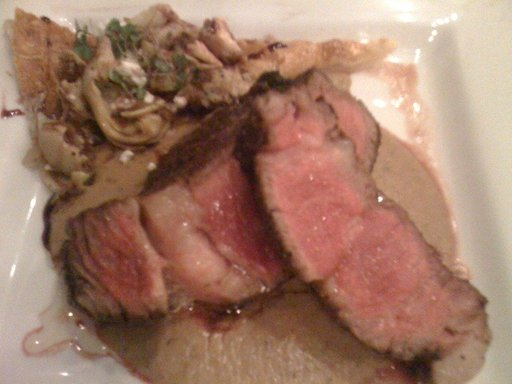

In [5]:
import random
from PIL import Image

random.seed(42)

#Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get the image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

img

(-0.5, 511.5, 383.5, -0.5)

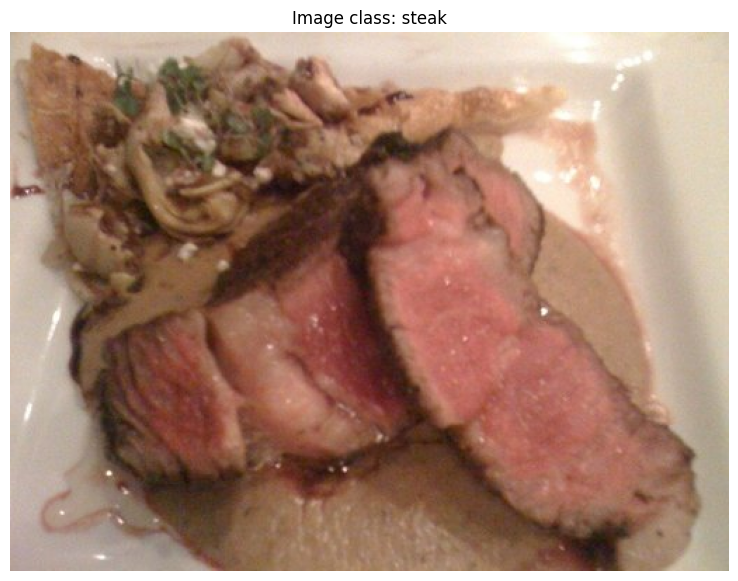

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}")
plt.axis(False)



---

### **Transforming data**

---



In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
# Transforming data with torchvision.transforms
data_transform = transforms.Compose([
    # Resize our images
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.tensor
    transforms.ToTensor()
])

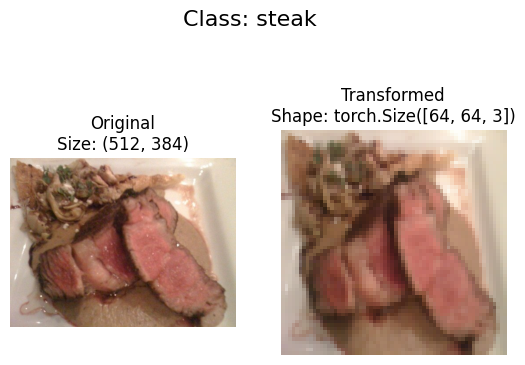

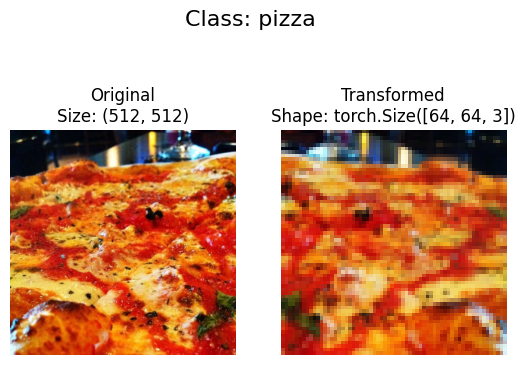

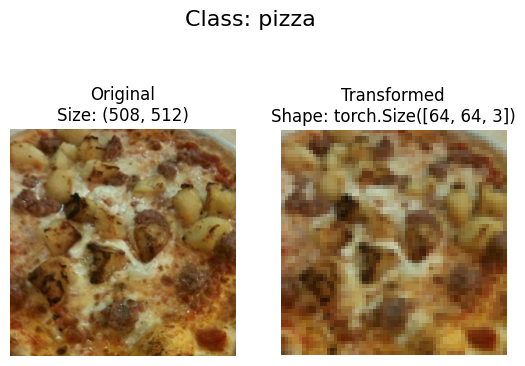

In [9]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transfom and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)



---

### **Loading image data using 'ImageFolder'**

---



In [10]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label

In [11]:
class_names = train_data.classes
class_dict = train_data.class_to_idx



---

### **Turn loaded images into DataLoaders**

---



In [12]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)



---

### **Creating custom dataset class in PyTorch**

---



In [13]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [14]:
# Creating a helper function to get class names
target_directory = train_dir

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

In [15]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # Get the class names by scanning target directory
  classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

  # Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")

  # Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [16]:
# Create a custom Dataset to replicate ImageFolder
from torch.utils.data import Dataset

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [17]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [18]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform=train_transforms
)

test_data_custom = ImageFolderCustom(
    targ_dir=test_dir,
    transform=test_transforms
)



---

### **Turning custom loaded images into dataloader**

---



In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(
    dataset = train_data_custom,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True
)

test_dataloader_custom = DataLoader(
    dataset = test_data_custom,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)



---

### **Data Augmentation**

---



In [20]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [21]:
image_path_list = list(image_path.glob("*/*/*.jpg"))



---

# **Building baseline model**

---



In [22]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root = train_dir,
    transform = simple_transform
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform
)

In [23]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

In [24]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [25]:
torch.manual_seed(42)
model0 = TinyVGG(input_shape=3, # 3 color channels
                 hidden_units=8,
                 output_shape=len(class_names)).to(device)

In [26]:
!pip install torchinfo



---

### **Using TorchInfo**

---



In [27]:
from torchinfo import summary
summary(model0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 8, 30, 30]           --
│    └─Conv2d: 2-1                       [32, 8, 62, 62]           224
│    └─ReLU: 2-2                         [32, 8, 62, 62]           --
│    └─Conv2d: 2-3                       [32, 8, 60, 60]           584
│    └─ReLU: 2-4                         [32, 8, 60, 60]           --
│    └─MaxPool2d: 2-5                    [32, 8, 30, 30]           --
├─Sequential: 1-2                        [32, 8, 13, 13]           --
│    └─Conv2d: 2-6                       [32, 8, 28, 28]           584
│    └─ReLU: 2-7                         [32, 8, 28, 28]           --
│    └─Conv2d: 2-8                       [32, 8, 26, 26]           584
│    └─ReLU: 2-9                         [32, 8, 26, 26]           --
│    └─MaxPool2d: 2-10                   [32, 8, 13, 13]           --
├─Sequentia

In [28]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [29]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [30]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [31]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model0_results = train(model=model0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0844 | train_acc: 0.3984 | test_loss: 1.0607 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4219 | test_loss: 1.0655 | test_acc: 0.5644
Total training time: 7.816 seconds


In [32]:
# Plot the loss curves of model0
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

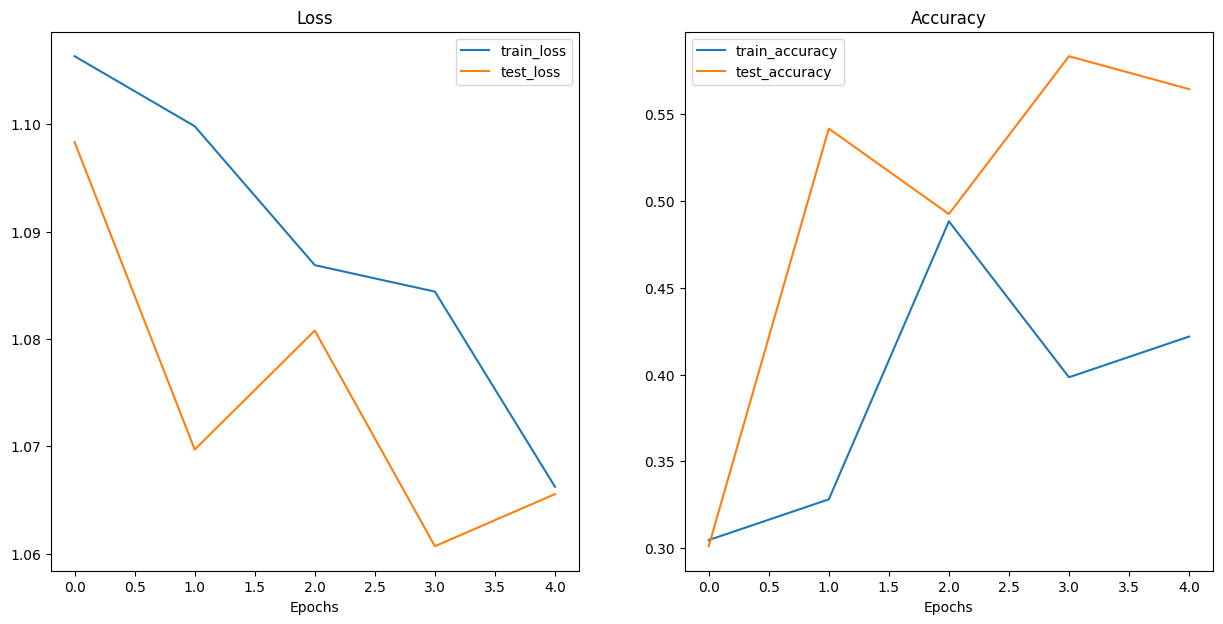

In [33]:
plot_loss_curves(model0_results)



---

# **Improved model building with data augmentation**

---



In [34]:
# Create transform with data augmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [35]:
# Create train and test Dataset and DataLoaders with data augmentation
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_trivial
)

In [36]:
import os
from torch.utils.data import DataLoader

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=32,
                                        shuffle=True,
                                        num_workers=os.cpu_count())

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=32,
                                        shuffle=False,
                                        num_workers=os.cpu_count())

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model1 = TinyVGG(input_shape=3, hidden_units=8, output_shape=len(train_data_augmented.classes)).to(device)

In [38]:
start_time_model1 = timer()

model1_results = train(model=model1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5)

end_time_model1 = timer()

print(f"Total training time for model1: {end_time_model1-start_time_model1: .3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0948 | train_acc: 0.4023 | test_loss: 1.0872 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.1047 | train_acc: 0.2812 | test_loss: 1.0872 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1003 | train_acc: 0.2812 | test_loss: 1.0872 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.1048 | train_acc: 0.2812 | test_loss: 1.0872 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1045 | train_acc: 0.2812 | test_loss: 1.0872 | test_acc: 0.5417
Total training time for model1:  5.353 seconds.


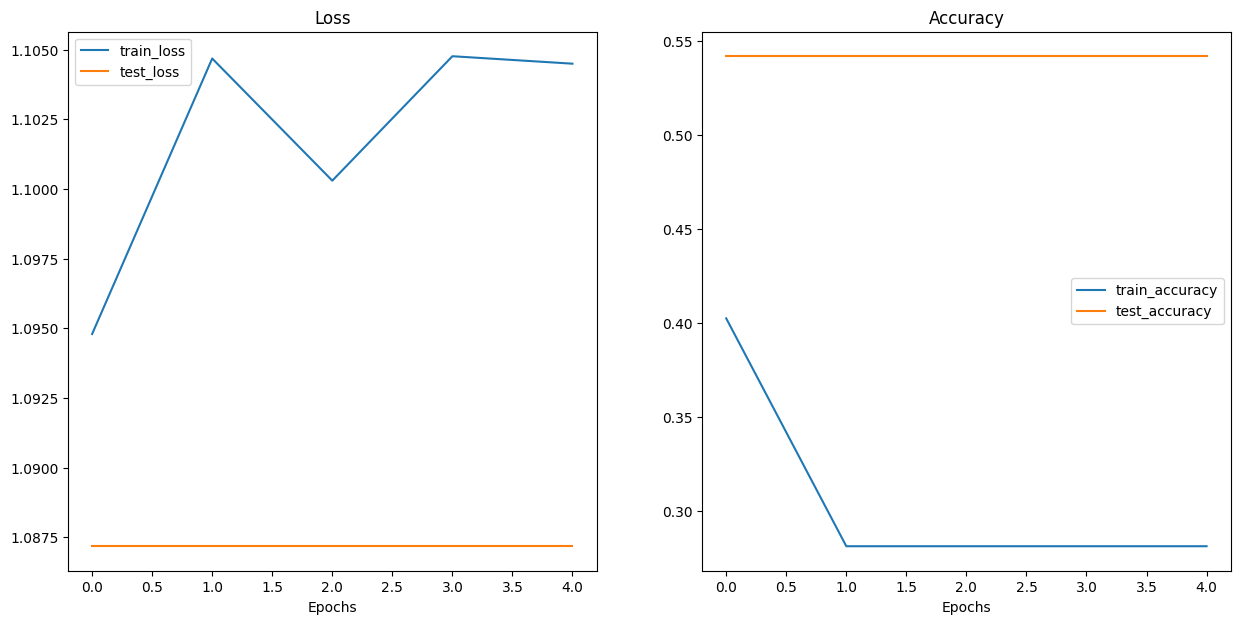

In [39]:
plot_loss_curves(model1_results)



---

## **Compare model results**

---



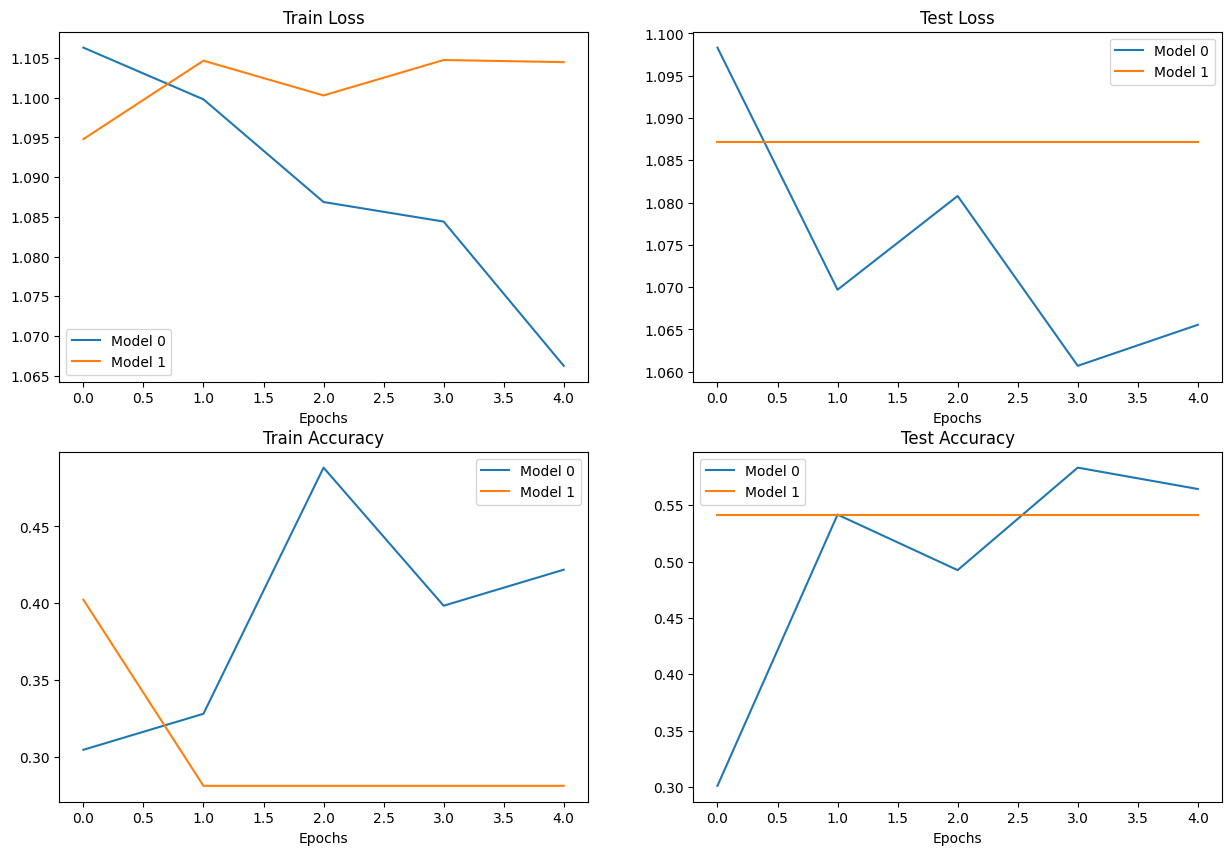

In [40]:
import pandas as pd

model0_df = pd.DataFrame(model0_results)
model1_df = pd.DataFrame(model1_results)

plt.figure(figsize=(15, 10))

epochs = range(len(model0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model0_df["train_loss"], label="Model 0")
plt.plot(epochs, model1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model0_df["test_loss"], label="Model 0")
plt.plot(epochs, model1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model0_df["train_acc"], label="Model 0")
plt.plot(epochs, model1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model0_df["test_acc"], label="Model 0")
plt.plot(epochs, model1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [41]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);